# Quantum chemistry on the QLM

The **Variational Quantum Eigensolver** method solves the following minimization problem :
$$
E = \min_{\vec{\theta}}\; \langle \psi(\vec{\theta}) \,|\, \hat{H} \,|\, \psi(\vec{\theta}) \rangle
$$

Here, we use a **Unitary Coupled Cluster** trial state, of the form:
$$
|\psi(\vec{\theta})\rangle = e^{\hat{T}(\vec{\theta}) - \hat{T}^\dagger(\vec{\theta})} |0\rangle
$$
where $\hat{T}(\theta)$ is the *cluster operator*: 
$$
\hat{T}(\vec{\theta}) = \hat{T}_1(\vec{\theta}) + \hat{T}_2(\vec{\theta}) + \cdots
$$
where
$$
\hat{T}_1 = \sum_{a\in U}\sum_{i \in O} \theta_a^i\, \hat{a}_a^\dagger \hat{a}_i \qquad
\hat{T}_2 = \sum_{a>b\in U}\sum_{i>j\in O} \theta_{a, b}^{i, j}\, \hat{a}^\dagger_a \hat{a}^\dagger_b \hat{a}_i \hat{a}_j \qquad
\cdots
$$
($O$ is the set of occupied orbitals and $U$, the set of unoccupied ones.)

## Example: $LiH$ molecule

One has to first describe the geometry and atomic content of the molecule (in this case, $LiH$).

This is done, in the cell below, using the open-source ``pySCF`` package. We specify the chosen basis set and the studied geometry. Here, we chose to study dihydrogen in the so-called STO-3G basis at 1.75 Angström (internuclear distance.)

In [2]:
import numpy as np

from qat.fermion.chemistry.pyscf_tools import perform_pyscf_computation

# LiH
geometry = [("Li", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 1.75))]
basis = "6-31g"
spin = 0
charge = 0

"""Other examples:

# H2
geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, 0.7414))]
basis = "sto-3g"
spin = 0  # = 2 S with S total spin angular momentum = # of unpaired electrons
charge = 0

# CO2
geometry = [['C', [0.0, 0.0, 8.261342997000753e-07]],
            ['O', [1.0990287608769004e-18, 2.7114450405987004e-19, 1.2236575813458745]],
            ['O', [2.696319376811295e-22, 2.4247676462727696e-23, -1.2236561920609494]]]
basis = "sto-3g"
spin = 1
"""

(
    rdm1,
    orbital_energies,
    nuclear_repulsion,
    n_electrons,
    one_body_integrals,
    two_body_integrals,
    info,
) = perform_pyscf_computation(geometry=geometry, basis=basis, spin=spin, charge=charge, verbose=True)

# rdm1 = (rdm1[0] + rdm1[1]) / 2. # For CO2
print("Number of qubits before active space selection = ", rdm1.shape[0] * 2)

HF energy= -7.978244325721487
MP2 energy= -7.991271632153249
FCI energy= -7.998354311186411
Number of qubits before active space selection =  22


## Active space selection

Based on the (approximate) one-particle reduced density matrix computed above (``rdm1``), we compute the so-called "natural-orbital occupation numbers" (NOONs). We use them to select, with a given threshold, the "active space orbitals" (which are contained in the ``active_indices`` list below). We then compute the Hamiltonian in this active space: we obtain ``H_active``.

In [3]:
from qat.fermion.chemistry import transform_integrals_to_new_basis

noons, basis_change = np.linalg.eigh(rdm1)
noons = list(reversed(noons))  # need to put noons in decreasing order
basis_change = np.flip(basis_change, axis=1)
one_body_integrals, two_body_integrals = transform_integrals_to_new_basis(one_body_integrals, two_body_integrals, basis_change)
from qat.fermion.chemistry.ucc import get_active_space_hamiltonian

H_active, active_inds, occ_inds = get_active_space_hamiltonian(
    one_body_integrals,
    two_body_integrals,
    noons,
    n_electrons,
    nuclear_repulsion,
    threshold_1=0.02,
    threshold_2=0.002,
)

print("Number of qubits after active space selection =", H_active.nbqbits)

print("Active-space Hamiltonian:", H_active)

Number of qubits after active space selection = 4
Active-space Hamiltonian: -6.932570947994952 * I^4 +
(-0.7481478037025496+0j) * (Cc|[0, 0]) +
(-0.13708046578883898+0j) * (Cc|[0, 2]) +
(-0.7481478037025496+0j) * (Cc|[1, 1]) +
(-0.13708046578883898+0j) * (Cc|[1, 3]) +
(-0.1370804657888388+0j) * (Cc|[2, 0]) +
(-0.3628682458484792+0j) * (Cc|[2, 2]) +
(-0.1370804657888388+0j) * (Cc|[3, 1]) +
(-0.3628682458484792+0j) * (Cc|[3, 3]) +
(0.22589467300409907+0j) * (CCcc|[0, 1, 1, 0]) +
(0.06717915702453613+0j) * (CCcc|[0, 1, 1, 2]) +
(0.06717915702453613+0j) * (CCcc|[0, 1, 3, 0]) +
(0.05849466486038482+0j) * (CCcc|[0, 1, 3, 2]) +
(0.05849466486038483+0j) * (CCcc|[0, 2, 0, 2]) +
(0.20090542896365177+0j) * (CCcc|[0, 2, 2, 0]) +
(0.06717915702453615+0j) * (CCcc|[0, 3, 1, 0]) +
(0.05849466486038483+0j) * (CCcc|[0, 3, 1, 2]) +
(0.20090542896365177+0j) * (CCcc|[0, 3, 3, 0]) +
(0.0603741471536337+0j) * (CCcc|[0, 3, 3, 2]) +
(0.22589467300409907+0j) * (CCcc|[1, 0, 0, 1]) +
(0.06717915702453613+0j) * (C

## Computation of cluster operators $T$ and good guess $\vec{\theta}_0$

We now construct the cluster operators (``cluster_ops``) defined in the introduction part as $\hat{T}(\vec{\theta})$, as well as a good starting parameter $\vec{\theta}$ (based on MP2 theory).

In [4]:
from qat.fermion.chemistry.ucc_deprecated import guess_init_state, get_cluster_ops

active_noons, active_orb_energies = [], []
for ind in active_inds:
    active_noons.extend([noons[ind], noons[ind]])
    active_orb_energies.extend([orbital_energies[ind], orbital_energies[ind]])
nb_active_els = n_electrons - 2 * len(occ_inds)

(
    theta_0,
    hf_init,
    actives_occupied_orbitals,
    actives_unoccupied_orbitals,
) = guess_init_state(nb_active_els, active_noons, active_orb_energies, H_active.hpqrs)

cluster_ops = get_cluster_ops(active_noons, actives_occupied_orbitals, actives_unoccupied_orbitals)

print("Initial theta:", theta_0)

Initial theta: [0, 0, 0.19640341378148707]


/tmp/ipykernel_603687/3295081378.py:14: UserWarning: This guess_init_state function is deprecated.
  ) = guess_init_state(nb_active_els, active_noons, active_orb_energies, H_active.hpqrs)
/tmp/ipykernel_603687/3295081378.py:16: UserWarning: This get_cluster_ops function is deprecated.
  cluster_ops = get_cluster_ops(


## Encode to qubits: Fermion-spin transformation


All the above operators are fermion operators. We now transform them to spin (or qubit) space. There are different possible choices. Here, we choose the Jordan-Wigner transform (the commented out imports show how to use the other transforms that are available on QLM).

In [5]:
from qat.fermion.transforms import recode_integer
from qat.fermion.transforms import transform_to_jw_basis, get_jw_code

# from qat.fermion.transforms import transform_to_bk_basis, get_bk_code
# from qat.fermion.transforms import transform_to_parity_basis, get_parity_code

transform, code = transform_to_jw_basis, get_jw_code  # Jordan Wigner
# transform, code = transform_to_bk_basis, get_bk_code #Bravyi Kitaev
H_active_sp = transform(H_active)

# expressing the cluster operator in spin terms
cluster_ops_sp = [transform(t_o) for t_o in cluster_ops]
# encoding the initial state to new encoding
hf_init_sp = recode_integer(hf_init, code(H_active_sp.nbqbits))

# Finally: build_uccsd
from qat.fermion.chemistry.ucc import construct_ucc_ansatz

qprog = construct_ucc_ansatz(cluster_ops_sp, hf_init_sp, n_steps=1)
circ = qprog.to_circ()

## Optimize the angles of $\psi(\vec{\theta})$ for a given QPU

We can now use the QLM's variational plugins to perform the VQE optimization.

/home/moliva/.local/lib/python3.9/site-packages/cotengra/hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


Minimum energy = -7.995936018594226
FCI energy: -7.998354311186411


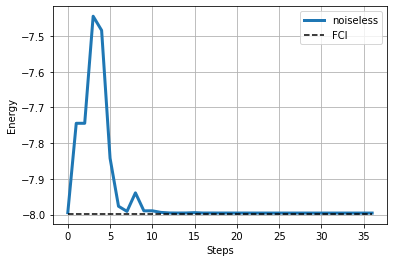

In [6]:
job = circ.to_job(job_type="OBS", observable=H_active_sp, nbshots=0)

from qat.qpus import LinAlg
from qat.vsolve.optimize import ScipyMinimizePlugin

optimizer_scipy = ScipyMinimizePlugin(method="COBYLA", tol=1e-3, options={"maxiter": 1000}, x0=theta_0)
qpu = optimizer_scipy | LinAlg()
result = qpu.submit(job)

print("Minimum energy =", result.value)
print("FCI energy:", info["FCI"])

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result.meta_data["optimization_trace"]), label="noiseless", lw=3)
plt.plot(
    [info["FCI"] for _ in range(len(eval(result.meta_data["optimization_trace"])))],
    "--k",
    label="FCI",
)
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

## With a Noisy QPU

We can easily switch to another QPU. Here, we want to investigate the effect of noise on VQE accuracy.
To this end, we use a noisy QPU with a simple noise model with $T_1$ and $T_2$ noise.

In [7]:
from qat.hardware import HardwareModel, DefaultGatesSpecification
from qat.quops import ParametricAmplitudeDamping, ParametricPureDephasing
from qat.qpus import NoisyQProc
from qat.plugins import StatPlugin

gate_durations = {
    "Z": 60,
    "H": 60,
    "X": 60,
    "Y": 60,
    "RX": lambda angle: 60,
    "RY": lambda angle: 60,
    "RZ": lambda angle: 60,
    "CNOT": 150,
}  # nanosecs
T1 = 50000  # = 50 microsecs
T2 = 50000

amp_damping = ParametricAmplitudeDamping(T_1=T1)
pure_dephasing = ParametricPureDephasing(T_phi=1 / (1 / T2 - 1 / (2 * T1)))
hw_model = HardwareModel(DefaultGatesSpecification(gate_durations), idle_noise=[amp_damping, pure_dephasing])
noisy_qpu = NoisyQProc(hardware_model=hw_model, sim_method="deterministic-vectorized")


qpu = StatPlugin() | optimizer_scipy | noisy_qpu
result_n = qpu.submit(job)
print("Minimum energy =", result_n.value)

=== StatPlugin:compile ===
Job 0: {'nbqbits': 4, 'size': 158, 'gates': {'custom gate': 0, 'X': 2, 'RX': 40, 'H': 40, 'CNOT': 64, 'RZ': 12}, 'measurements': 0, 'resets': 0, 'logic': 0, 'breaks': 0, 'remaps': 0, 'gate_size': 158}
Minimum energy = -7.89539551389922


## Comparison: noiseless vs. noisy

As you can see, the final energy obtained with a noisy QPU is higher than the one obtained with a perfect (noiseless) QPU:

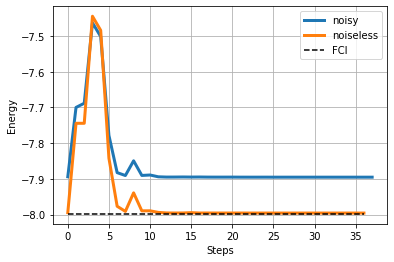

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result_n.meta_data["optimization_trace"]), label="noisy", lw=3)
plt.plot(eval(result.meta_data["optimization_trace"]), label="noiseless", lw=3)
plt.plot(
    [info["FCI"] for _ in range(len(eval(result.meta_data["optimization_trace"])))],
    "--k",
    label="FCI",
)
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

## VQE with noise + constraints:

We now add another layer of complexity by adding connectivity constraints to the QPU. This is done via the ``QuameleonPlugin``. As a result of these constraints, the circuit needs to be compiled. This task is carried out by yet another QLM plugin, the ``Nnizer`` (see also the ``LazySynthesis`` plugin that carries out a similar task). Notice how the gate count (printed through the ``StatPlugin`` plugin) has increased with respect to the original circuit:

In [9]:
import json
from qat.core import Topology, HardwareSpecs, TopologyType
from qat.plugins import Nnizer, QuameleonPlugin, Remap

graph_dict = json.load(open("graph_ibmqx5.json", "r"))["edges"]  # we load a graph (here corresponding to IBM QX5' chip)
graph = {int(vertex): edges for vertex, edges in graph_dict.items()}
topology = Topology(type=TopologyType.CUSTOM, is_directed=False, graph=graph)
hw_specs = HardwareSpecs(nbqbits=16, topology=topology)
nnizer = Nnizer()

# the Remap plugin below allows for a smart remapping of qubits to minimize the qubit count
noisy_qpu_with_topology = QuameleonPlugin(specs=hw_specs) | (Remap() | noisy_qpu)
qpu = Nnizer() | StatPlugin() | optimizer_scipy | noisy_qpu_with_topology
result_nn = qpu.submit(job)
print("Minimum energy =", result_nn.value)

=== StatPlugin:compile ===
Job 0: {'nbqbits': 16, 'size': 503, 'gates': {'custom gate': 0, 'X': 2, 'RX': 40, 'H': 328, 'CNOT': 121, 'RZ': 12}, 'measurements': 0, 'resets': 0, 'logic': 0, 'breaks': 0, 'remaps': 0, 'gate_size': 503}
Minimum energy = -7.777753535782647


## Final comparison

Below, we compare the convergence of the VQE energy for the different QPUs. As expected, in the presence of noise and connectivity constraints, the VQE energy is highest because connectivity constraints lead to longer circuits that in turn lead to a higher sensitivity to decoherence.

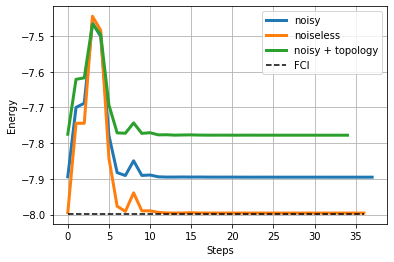

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result_n.meta_data["optimization_trace"]), label="noisy", lw=3)
plt.plot(eval(result.meta_data["optimization_trace"]), label="noiseless", lw=3)
plt.plot(eval(result_nn.meta_data["optimization_trace"]), label="noisy + topology", lw=3)
plt.plot(
    [info["FCI"] for _ in range(len(eval(result.meta_data["optimization_trace"])))],
    "--k",
    label="FCI",
)
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid()

## Further questions to be investigated:

This notebook only tackles certain aspects of performing chemistry on the QLM with advanced QPUs and Plugins. Other questions that you can deal with using other QLM tools include:

- how to reduce the gate count given a topology?
- how to rewrite a circuit for another gate set (say, for ions)?
- how to mitigate noise effects? (zero-noise extrapolation...)